In [3]:
### dependencies ###
# !pip install cvxpy
# !pip install mystic

In [4]:
%matplotlib inline

# import cvxpy as cp
import numpy as np

import scipy.optimize as opt

import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
# # verify runway plot

# t_sim = 10 # seconds

# center_line_x = np.zeros((t_sim,))
# left_boundary_x = np.ones((t_sim,)) * -10
# right_boundary_x = np.ones((t_sim)) * 10

# center_line_y = np.linspace(0, t_sim, t_sim)
# left_boundary_y = np.linspace(0, t_sim, t_sim)
# right_boundary_y = np.linspace(0, t_sim, t_sim)

# plt.figure(figsize=(20, 3))
# plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
# plt.plot(left_boundary_y, left_boundary_x, color='black')
# plt.plot(right_boundary_y, right_boundary_x, color='black')

In [71]:
### function to plot trajectory ###

def rotate(x, y, angle):
    return [x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)), 
            x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))]

def plot_trajectory(states, angle=0, runway_length=(-100, 100), runway_boundaries=(-10, 10)):

    center_line_x = np.zeros((runway_length[1] - runway_length[0],))
    left_boundary_x = np.ones((runway_length[1] - runway_length[0],)) * runway_boundaries[0]
    right_boundary_x = np.ones((runway_length[1] - runway_length[0])) * runway_boundaries[1]

    center_line_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    left_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])
    right_boundary_y = np.linspace(runway_length[0], runway_length[1], runway_length[1] - runway_length[0])

    plt.figure(figsize=(20, 3))
    plt.plot(center_line_y, center_line_x, color='gold', linestyle='--')
    plt.plot(left_boundary_y, left_boundary_x, color='black')
    plt.plot(right_boundary_y, right_boundary_x, color='black')
    
    colors = cm.rainbow(np.linspace(0, 1, int(len(states)//6)))
    for i in range(0, len(states), 6):
        x, y, _, _, _, _ = states[i:i+6]
        x, y = rotate(x, y, angle)
        plt.plot(x, y, marker='o', markersize=5, color=colors[int(i//6)])   

### print states after getting result ###
        
def print_states(states):
    for i in range(0, len(states), 6):
        print("state {}:".format(int(i//6) + 1))
        output_states = np.round(states[i:i+6], 5)
        print("\tx: {}, y: {}, velocity: {}, heading: {}\n\tacceleration: {}, angular velocity: {}\n".\
              format(output_states[0], output_states[1], output_states[2], output_states[3], 
                     output_states[4], output_states[5]))

In [115]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.array([rho, phi])

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.array([x, y])

***States and Parameters Setup***

In [116]:
### states setup ###

init_heading = 90 # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0

# want to end here at t = sim_time
desired_x = 0
desired_y = 100

desired_velocity = 30 # m/s

acceleration_constraint = 5 # m/s^2
turning_constraint = 60 # degrees

time_step = 1
sim_time = 10

guess_range = (0, 10)

In [153]:
### xplane test states setup ###

zero_heading = 270
runway_heading = 54.331

init_heading = zero_heading + runway_heading # degrees
init_velocity = 0 # m/s

init_acceleration = 0 # m/s^2
init_turning = 0 # degrees/s

# start here at t = 0
init_x = 0
init_y = 0 

# want to end here at t = sim_time
desired_x = 2421
desired_y = -1737

desired_velocity = 30 # m/s

acceleration_constraint = 7 # m/s^2
turning_constraint = 100 # degrees

time_step = 1
sim_time = 10

wind_offset = 90
wind_strength = 100 
wind_dynamics = [wind_strength, runway_heading + wind_offset + zero_heading]

plane_cs = 27.41 # square meters
plane_mass = 6175 * 0.45359237 # lbs -> kg

plane_specs = [plane_cs, plane_mass]

***Controller Optimzed Over Controls***

In [154]:
def compute_states(init_state, controls, wind_dynamics, plane_specs, time_step=1):
    states = []
    x, y, v, h = init_state
    wind_speed, wind_heading = wind_dynamics
    plane_cs, plane_mass = plane_specs
    wind_acc = wind_speed * plane_cs / plane_mass
    for i in range(0, len(controls), 2):
        a, w = controls[i:i+2]
        states = np.concatenate((states, [x, y, v, h, a, w]))
        vx = (v * np.cos(np.radians(h))) + (time_step * wind_acc * np.cos(np.radians(wind_heading)))
        vy = (v * np.sin(np.radians(h))) + (time_step * wind_acc * np.sin(np.radians(wind_heading)))
        x += time_step * vx
        y += time_step * vy
        v += time_step * a
        h += time_step * w
        h %= 360
    return states


def rejection_dist(desired_x, desired_y, curr_x, curr_y):
    a = np.array([desired_x, desired_y])
    b = np.array([curr_x, curr_y])
    projection = a@b / np.linalg.norm(a, ord=2)**2 * a
    proj_x, proj_y = projection
    return np.linalg.norm([curr_x - proj_x, curr_y - proj_y], ord=2) ** 2


def formulate_objective(init_states, desired_states, environment, plane_specs, time_step=1, 
                        state_weight=0.1, control_weight=0.1, constraint_weight=0.1, dstate_weight=0.001, 
                        fvelocity_weight=5):
    desired_x, desired_y, desired_v = desired_states
    def objective(params):
        states = compute_states(init_states, params, environment, plane_specs, time_step=time_step)
        cost = control_weight * np.linalg.norm(np.vstack([params[0], params[1]]), ord=2) ** 2
        for i in range(6, len(states) - 6, 6):
            px, py, v, h, a, w = states[i:i+6]
            # closest centerline point
            cost += constraint_weight * rejection_dist(desired_x, desired_y, px, py)
            cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
            cost += state_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py]), ord=2)
            cost += fvelocity_weight * np.linalg.norm([desired_v - v], ord=20)
        px, py, v, h, a, w = states[-6:]
        cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py]), ord=2)
        cost += fvelocity_weight * np.linalg.norm([desired_v - v], ord=2)
        return cost
    return objective


def formulate_guess(sim_time):
    return np.zeros((sim_time*2,))
    
    
state0 = [init_x, init_y, init_velocity, init_heading]
init_guess = formulate_guess(sim_time)
bounds = [(-acceleration_constraint, acceleration_constraint), 
          (-turning_constraint, turning_constraint)] * sim_time

obj = formulate_objective(state0, [desired_x, desired_y, desired_velocity], wind_dynamics, plane_specs, time_step=time_step, 
                          state_weight=1, constraint_weight=2, control_weight=0.5, dstate_weight=5, fvelocity_weight=7)

result = opt.minimize(obj, init_guess, method='SLSQP', bounds=bounds,
                      options={'eps': 0.01, 'maxiter': 1000})
result

     fun: 37728.41336185152
     jac: array([-5.59526266e+01,  2.27439643e+00, -3.60722282e+01,  2.21080007e+00,
       -1.73226181e+01,  2.07503595e+00, -4.84425771e-02,  1.68384695e+00,
        1.16166630e+01,  8.79930820e-01,  9.70750255e+00,  1.17012163e-01,
        9.83167490e+00, -1.24414643e-01,  8.86406406e+00, -1.82414326e-02,
        7.01083664e+00,  5.55271981e-05,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 569
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([ 7.00000000e+00, -3.32021699e+00,  7.00000000e+00, -1.52755665e+00,
        7.00000000e+00,  4.63102250e-01,  7.00000000e+00,  1.33645433e+00,
        2.61802677e+00,  9.33467702e-01, -2.98260227e-01,  2.48493629e-01,
       -1.76335908e-01,  6.71926632e-03, -1.43430686e-01,  5.92124657e-02,
        5.83722903e-03, -4.94447384e-03,  0.00000000e+00,  0.00000000e+00])

state 1:
	x: 0.0, y: 0.0, velocity: 0.0, heading: 324.331
	acceleration: 7.0, angular velocity: -3.32022

state 2:
	x: 0.57062, y: 0.79502, velocity: 7.0, heading: 321.01078
	acceleration: 7.0, angular velocity: -1.52756

state 3:
	x: 6.5821, y: -2.81419, velocity: 14.0, heading: 319.48323
	acceleration: 7.0, angular velocity: 0.4631

state 4:
	x: 17.79575, y: -11.11456, velocity: 21.0, heading: 319.94633
	acceleration: 7.0, angular velocity: 1.33645

state 5:
	x: 34.44065, y: -23.83315, velocity: 28.0, heading: 321.28278
	acceleration: 2.61803, angular velocity: 0.93347

state 6:
	x: 56.85807, y: -40.55149, velocity: 30.61803, heading: 322.21625
	acceleration: -0.29826, angular velocity: 0.24849

state 7:
	x: 81.627, y: -58.51562, velocity: 30.31977, heading: 322.46474
	acceleration: -0.17634, angular velocity: 0.00672

state 8:
	x: 106.24055, y: -76.1929, velocity: 30.14343, heading: 322.47146
	acceleration: -0.14343, angular velocity: 0.05921

state 9:
	x: 130.71643, y: -93.75995, v

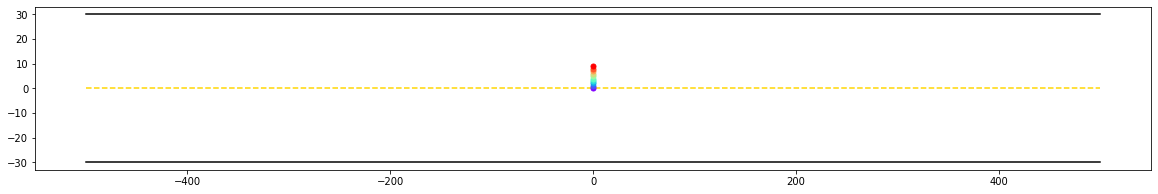

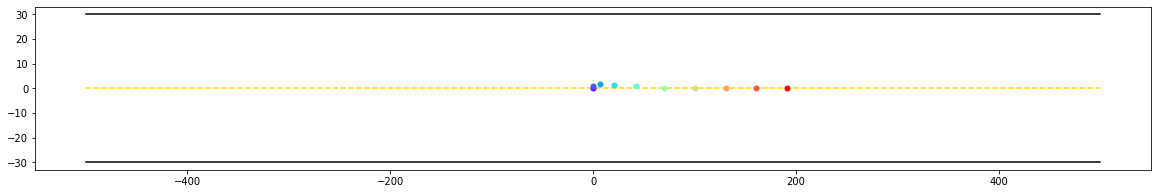

In [155]:
r_runway = -(runway_heading + zero_heading - 360)

guess_traj = compute_states(state0, init_guess, wind_dynamics, plane_specs)
solved_traj = compute_states(state0, result.x, wind_dynamics, plane_specs)

plot_trajectory(guess_traj, angle=r_runway, runway_length=(-500, 500), runway_boundaries=(-30, 30))
plot_trajectory(solved_traj, angle=r_runway, runway_length=(-500, 500), runway_boundaries=(-30, 30))

print_states(solved_traj)

***Controller Optimized Over States***

In [12]:
# def shape_states(variables):
#     states = variables[:4]
#     controls = np.concatenate(([0, 0], variables[4:6]))
#     controls[0] = states[2] * np.cos(np.radians(states[3]))
#     controls[1] = states[2] * np.sin(np.radians(states[3]))
#     return states, controls


# def formulate_objective(desired_x, desired_y, desired_v, state_weight=0.1, control_weight=0.1, 
#                         constraint_weight=0.1, dstate_weight=0.001):
#     def objective(params):
#         cost = 0
#         cost += control_weight * np.linalg.norm(np.vstack([params[4], params[5]]), ord=2) ** 2
#         for i in range(6, len(params) - 6, 6):
#             px, py, v, h, a, w = params[i:i+6]
#             cost += constraint_weight * np.linalg.norm([px], ord=2) ** 2
#             cost += control_weight * np.linalg.norm(np.vstack([a, w]), ord=2) ** 2
#             cost += np.linalg.norm([desired_v - v], ord=2) ** 2
#         px, py, v, h, a, w = params[-6:]
#         cost += dstate_weight * np.linalg.norm(np.vstack([desired_x - px, desired_y - py, desired_v - v]), ord=2)
#         return cost
#     return objective


# def formulate_constraints(state0, sim_time, ts=1):
#     def dynamic_constraints(params):
#         errors = np.zeros((sim_time,))
#         states_t, controls_t = shape_states(state0)
#         errors[0] = np.linalg.norm(params[:4] - states_t, ord=2)
#         for i in range(6, len(params), 6):    
#             states_t1, controls_t1 = shape_states(params[i:i+6])
#             # error[t+1] = norm(x_(t+1) - f(x_t, u_t))
#             errors[int(i // 6)] = np.linalg.norm(states_t1 - (states_t + ts * controls_t), ord=2)
#             states_t, controls_t = states_t1, controls_t1

#         return np.sum(errors)
#     return dynamic_constraints


# def formulate_guess(state0, sim_time, random_seed=0, ts=1):
    
#     guess_a = random.randint(guess_range[0], guess_range[1])
#     guess_w = random.randint(guess_range[0], guess_range[1])
#     state0_controlled = state0 + [guess_a, guess_w]
#     init_state = state0_controlled[:]
#     ix, iy, iv, ih, ia, iw = init_state
    
#     for _ in range(sim_time - 1):
        
#         new_x = ix + ts * iv * np.cos(np.radians(ih))
#         new_y = iy + ts * iv * np.sin(np.radians(ih))
#         new_v = iv + ts * ia
#         new_h = ih + ts * iw
#         guess_a = random.randint(guess_range[0], guess_range[1])
#         guess_w = random.randint(guess_range[0], guess_range[1])
#         init_state += [new_x, new_y, new_v, new_h, guess_a, guess_w]
        
#         ix, iy, iv, ih, ia, iw = new_x, new_y, new_v, new_h, guess_a, guess_w
        
#     return state0_controlled, np.array(init_state)

    
    
# state0 = [init_x, init_y, init_velocity, init_heading]
# state0, init_guess = formulate_guess(state0, sim_time, ts=time_step)

# con = formulate_constraints(state0, sim_time, ts=time_step)
# obj = formulate_objective(desired_x, desired_y, desired_velocity, state_weight=10, 
#                           constraint_weight=1, control_weight=0.5, dstate_weight=10)

# result = opt.minimize(obj, init_guess, method='SLSQP', 
#                       constraints={"fun": con, "type": "eq"},
#                       options={'eps': 0.01, 'maxiter': 1000})
# result

In [11]:
# def get_controls(variables):
#     controls = []
#     for i in range(0, len(variables), 6):
#         controls.append(variables[i+4])
#         controls.append(variables[i+5])
#     return controls

# ### verification for constraints ###

# def verify_output(state0, params, sim_time, ts=1):
#     errors = np.zeros((sim_time,))
#     init_states, init_controls = shape_states(params[:6])
#     errors[0] = np.linalg.norm(params[:4] - init_states, ord=2) ** 2

#     for i in range(6, len(params), 6):    
#         next_states, next_controls = shape_states(params[i:i+6])
#         errors[int(i // 6)] = np.linalg.norm(next_states - (init_states + ts * init_controls), ord=2) ** 2
#         init_states, init_controls = next_states, next_controls

#     return errors

# print("errors:", verify_output(state0, result.x, sim_time, ts=time_step), "\n")

# plot_trajectory(init_guess, runway_length=(-500, 500), runway_boundaries=(-30, 30))
# plot_trajectory(result.x, runway_length=(-500, 500), runway_boundaries=(-30, 30))
        
# print_states(result.x)